In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import os
import re

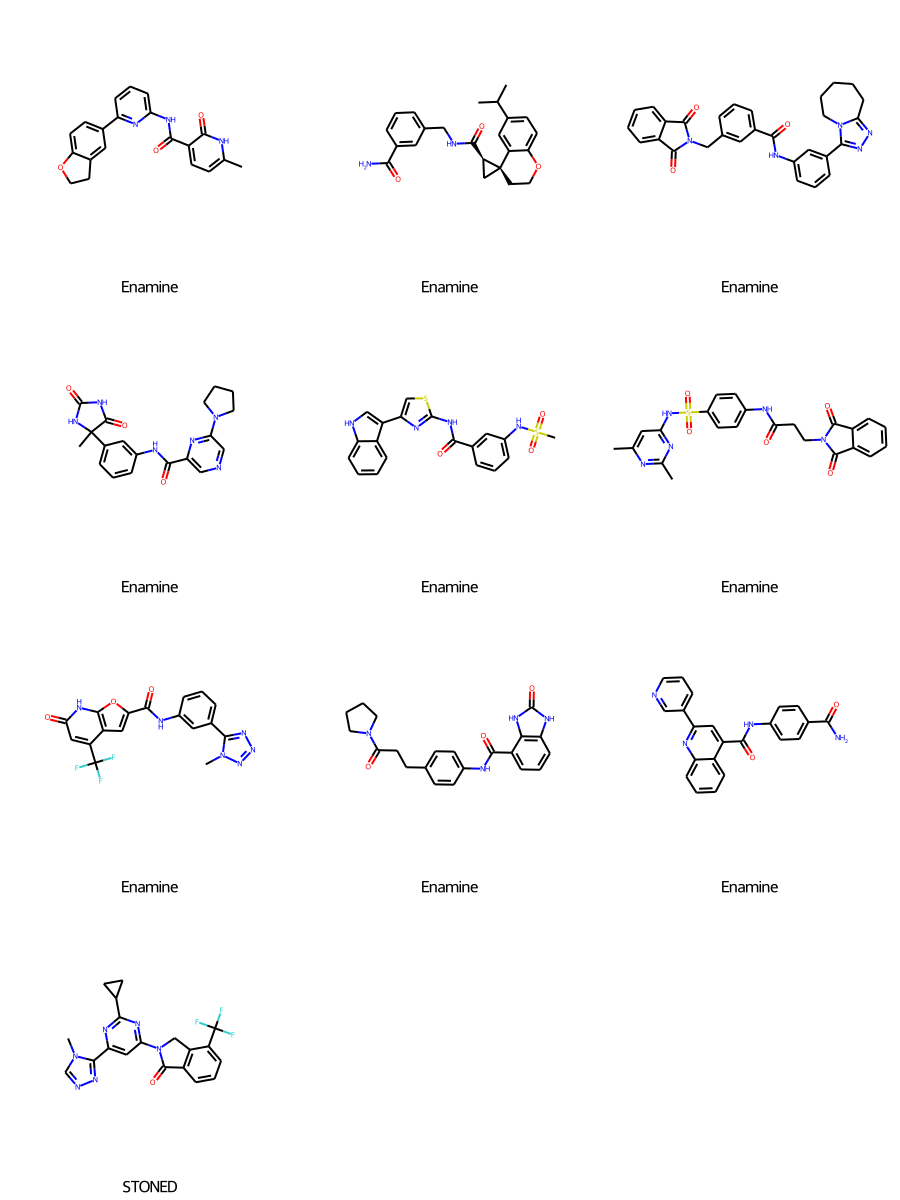

In [8]:
# SMILESのリストを渡してEnamineのカタログ化合物だったらFalse、STONEDで生成した化合物ならTrueのリストを返す
def check_stoned(stoned_csv, smi_list):
    is_stoned_list, stoned_smi_list = [], []
    df = pd.read_csv(stoned_csv)
    for smi in df['SMILES']:
        stoned_smi_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
    for smi in smi_list:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        if canon_smi in stoned_smi_list:
            is_stoned = True
        else:
            is_stoned = False
        is_stoned_list.append(is_stoned)
    return is_stoned_list

# pymol で目視で選んだ化合物の ./ex_smis/ における番号
smi_sub = ['00884', '00887', '01189', '01750', '01894', '02370', '03149', '03561', '04754', '04892']

smi_list = []
for num in smi_sub:
    with open(f'./ex_smis/extracted{num}.smi', 'r') as f:
        smi_list.append(f.read())
mols = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    mols.append(mol)
    
is_stoned_list = check_stoned(stoned_csv='./csv_out_stoned.csv', smi_list=smi_list)
legends = []
for i, value in enumerate(is_stoned_list):
    if value == True:
        legends.append('STONED')
    else:
        legends.append('Enamine')
Draw.MolsToGridImage(mols=mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)

In [4]:
# 提出するSMILES
for mol in mols:
    print(Chem.MolToSmiles(mol))

Cc1ccc(C(=O)Nc2cccc(-c3ccc4c(c3)CCO4)n2)c(=O)[nH]1
CC(C)c1ccc2c(c1)[C@]1(CCO2)C[C@H]1C(=O)NCc1cccc(C(N)=O)c1
O=C(Nc1cccc(-c2nnc3n2CCCCC3)c1)c1cccc(CN2C(=O)c3ccccc3C2=O)c1
CC1(c2cccc(NC(=O)c3cncc(N4CCCC4)n3)c2)NC(=O)NC1=O
CS(=O)(=O)Nc1cccc(C(=O)Nc2nc(-c3c[nH]c4ccccc34)cs2)c1
Cc1cc(NS(=O)(=O)c2ccc(NC(=O)CCN3C(=O)c4ccccc4C3=O)cc2)nc(C)n1
Cn1nnnc1-c1cccc(NC(=O)c2cc3c(C(F)(F)F)cc(=O)[nH]c3o2)c1
O=C(Nc1ccc(CCC(=O)N2CCCC2)cc1)c1cccc2[nH]c(=O)[nH]c12
NC(=O)c1ccc(NC(=O)c2cc(-c3cccnc3)nc3ccccc23)cc1
Cn1cnnc1-c1cc(N2Cc3c(cccc3C(F)(F)F)C2=O)nc(C2CC2)n1


In [18]:
def extract_number_from_string(string):
    match = re.search(r'\d+', string)
    return match.group(0) if match else None

# 既知リガンド895個の読み込み
ligand_list = []
for i, dir in enumerate(os.listdir('./known_ligands_smi')):
    num = extract_number_from_string(dir)
    file = f'./known_ligands_smi/{dir}'  # ここにファイル名を入れてください
    with open(f'./known_ligands_smi/ligand{num}.smi', 'r') as f:
        smi = f.readline()
        ligand_list.append(smi)

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

def calculate_tanimoto_coefficient(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    ecfp4_fingerprint1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=1024)
    ecfp4_fingerprint2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=1024)

    tanimoto_coefficient = TanimotoSimilarity(ecfp4_fingerprint1, ecfp4_fingerprint2)
    return tanimoto_coefficient

def calculate_max_tanimoto_coefficients(smi_list, ligand_list):
    max_tanimoto_coefficients = []

    for smi in smi_list:
        max_coefficient = 0

        for ligand in ligand_list:
            tanimoto_coefficient = calculate_tanimoto_coefficient(smi, ligand)

            if tanimoto_coefficient > max_coefficient:
                max_coefficient = tanimoto_coefficient

        max_tanimoto_coefficients.append(max_coefficient)

    return max_tanimoto_coefficients

max_tanimoto_coefficients = calculate_max_tanimoto_coefficients(smi_list, ligand_list)
print(f'Max Tanimoto coefficients: {max_tanimoto_coefficients}')


Max Tanimoto coefficients: [0.2823529411764706, 0.24742268041237114, 0.3068181818181818, 0.35, 0.30120481927710846, 0.2926829268292683, 0.36046511627906974, 0.22988505747126436, 0.2875, 0.6216216216216216]
